In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")
# if torch.backends.mps.is_available():
#     # Set MPS as the default device for all new tensors
#     torch.set_default_device('mps')
#     print("Default device set to MPS")
# else:
#     print("MPS not available, using CPU")
    
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'

gen = lambda : torch.Generator().manual_seed(2147483647)

PyTorch version: 2.6.0
MPS available: True
MPS built: True


In [2]:
words = open('names.txt', 'r').read().splitlines()
dataset_size = len(words)
print(f'{dataset_size=}')
words[:8]

dataset_size=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build vocabulary of characters and mapping to/from integers
special_character = '.'
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)} # string to int
stoi[special_character] = 0
itos = {i: s for s, i in stoi.items()} # int to string
V = len(stoi)

In [4]:
# build dataset
fused_steps = 8
def build_dataset(words: list[str], block_size: int = 3):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + special_character:
            idx = stoi[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    
    X, y = torch.tensor(X), torch.tensor(y)
    print(f'{X.shape=}, {y.shape=}')
    return X, y

random.seed(42)
random.shuffle(words)
n1 = int(dataset_size*.8)
n2 = int(dataset_size*.9)
X_train, y_train = build_dataset(words[:n1],fused_steps)    # 80%
X_dev, y_dev = build_dataset(words[n1:n2],fused_steps)      # 10%
X_test, y_test = build_dataset(words[n2:],fused_steps)      # 10%

X.shape=torch.Size([182625, 8]), y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 8]), y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 8]), y.shape=torch.Size([22866])


In [9]:
from typing import Any


class Linear:
    def __init__(self, fan_in: int, fan_out, bias: bool = True) -> None:
        self.weights: torch.Tensor = torch.randn((fan_in, fan_out)) / fan_in ** .5
        self.bias: torch.Tensor = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # learnable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers trained with a running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            if x.ndim ==2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            x_mean = x.mean(dim, keepdim=True)
            x_variance = x.var(dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_variance = self.running_var
        
        x_hat = (x-x_mean) / torch.sqrt(x_variance + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum * x_variance
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return[]
    
class  Embedding:
    def __init__(self, n_embeddings: int , embedding_dimensions:int) -> None:
        self.weights = torch.randn((n_embeddings, embedding_dimensions))
        
    def __call__(self, idx: torch.Tensor) -> Any:
        self.out = self.weights[idx]
        return self.out
    
    def parameters(self):
        return [self.weights]
    
class FlattenConsecutive:
    def __init__(self, n: int) -> None:
        self.fused_steps = n
        
    def __call__(self, x: torch.Tensor) -> Any:
        batch_size, time_steps, features = x.shape
        x = x.view(batch_size, time_steps//self.fused_steps, features*self.fused_steps)
        if x.shape[1] ==1:
            x=x.squeeze(1)
        self.out = x
        return self.out
        
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers: list) -> None:
        self.layers = layers
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [10]:
torch.manual_seed(42)

In [18]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(V, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, V)
])

with torch.no_grad():
    model.layers[-1].weights +=0.1
    
parameters =  model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

76579


In [19]:
idx = torch.randint(0, X_train.shape[0], (4,))
X_batch, y_batch = X_train[idx], y_train[idx]
logits = model(X_batch)
print(f'{X_batch.shape=}')
X_batch

X_batch.shape=torch.Size([4, 8])


tensor([[ 0,  0, 19, 21, 12,  1, 13,  9],
        [ 0,  0,  0, 11,  1, 18,  4,  9],
        [ 0,  0,  0,  0,  1, 13,  1,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [20]:
for layer in model.layers:
    print(f'{layer.__class__.__name__}: {tuple(layer.out.shape)}')

Embedding: (4, 8, 24)
FlattenConsecutive: (4, 4, 48)
Linear: (4, 4, 128)
BatchNorm1d: (4, 4, 128)
Tanh: (4, 4, 128)
FlattenConsecutive: (4, 2, 256)
Linear: (4, 2, 128)
BatchNorm1d: (4, 2, 128)
Tanh: (4, 2, 128)
FlattenConsecutive: (4, 256)
Linear: (4, 128)
BatchNorm1d: (4, 128)
Tanh: (4, 128)
Linear: (4, 27)


In [21]:
max_steps = 200_000
batch_size = 32
loss_i = []
start = time.time()
for i in range(max_steps):
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, y_batch = X_train[idx], y_train[idx]
    
    # forward pass
    logits = model(X_batch)
    loss = F.cross_entropy(logits, y_batch)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # updates
    
    lr = 0.1 if i < 150_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

runtime = time.time() - start
print(f'{runtime=}')
    

      0/  200000: 3.4191
  10000/  200000: 1.9597
  20000/  200000: 1.9828
  30000/  200000: 1.8847
  40000/  200000: 1.8838
  50000/  200000: 2.0015
  60000/  200000: 2.1990
  70000/  200000: 1.7240
  80000/  200000: 2.0121
  90000/  200000: 2.0880
 100000/  200000: 1.8503
 110000/  200000: 2.1979
 120000/  200000: 2.0661
 130000/  200000: 2.2988
 140000/  200000: 1.8350
 150000/  200000: 1.7871
 160000/  200000: 1.5410
 170000/  200000: 1.9475
 180000/  200000: 1.6456
 190000/  200000: 1.9213
runtime=271.9534888267517


cpu runtime=260.49666905403137


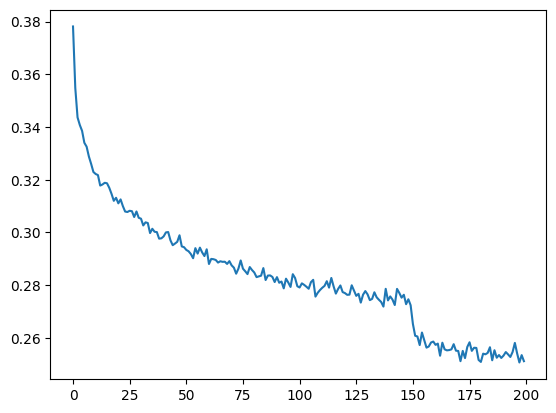

In [22]:
plt.plot(torch.tensor(loss_i).view(200,-1).mean(1))


In [23]:
for layer in model.layers:
    layer.training = False

In [24]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_dev, y_dev),
    'test': (X_test, y_test),
  }[split]
  
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.7699743509292603
val 1.9875608682632446


In [25]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * fused_steps # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amelia.
khyrir.
khaliyah.
cassie.
rahmeed.
perric.
kaeli.
neliah.
tziriah.
kaleigh.
hamond.
miquian.
sulivea.
jamil.
waverleigh.
yiir.
kaedyn.
sabrea.
ediia.


In [29]:
for x,y in zip(X_train[7:15], y_train[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [32]:
# forward a single example:
logits = model(X_train[[7]])
logits

tensor([[-6.3607,  0.7481, -0.3219, -0.1810, -0.0405, -0.0795, -1.5741, -1.0499,
         -0.7530, -1.0671,  0.2269,  0.6665, -0.2451,  0.4985, -0.7069, -1.5272,
         -1.0559, -2.9556,  0.0468,  0.1360, -0.2319, -3.4102, -1.6448, -1.8726,
         -2.5730, -1.2347, -0.6271]], grad_fn=<AddBackward0>)

In [34]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(X_train[[7+i]])
logits.shape

torch.Size([8, 27])